In [27]:
import torch
from sklearn.metrics import classification_report

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("device:", device)

device: cuda


# load data

In [2]:
from defi_textmine_2025.modeling.data_preparation import df_train, df_valid, mlb, entity_classes

 Delete this directory to recompute one-hot dataset.


In [3]:
target_list = mlb.classes_

print(target_list)

['CREATED' 'DEATHS_NUMBER' 'DIED_IN' 'END_DATE' 'GENDER_FEMALE'
 'GENDER_MALE' 'HAS_CATEGORY' 'HAS_COLOR' 'HAS_CONSEQUENCE'
 'HAS_CONTROL_OVER' 'HAS_FAMILY_RELATIONSHIP' 'HAS_FOR_HEIGHT'
 'HAS_FOR_LENGTH' 'HAS_FOR_WIDTH' 'HAS_LATITUDE' 'HAS_LONGITUDE'
 'HAS_QUANTITY' 'INITIATED' 'INJURED_NUMBER' 'IS_AT_ODDS_WITH'
 'IS_BORN_IN' 'IS_BORN_ON' 'IS_COOPERATING_WITH' 'IS_DEAD_ON'
 'IS_IN_CONTACT_WITH' 'IS_LOCATED_IN' 'IS_OF_NATIONALITY' 'IS_OF_SIZE'
 'IS_PART_OF' 'IS_REGISTERED_AS' 'OPERATES_IN' 'RESIDES_IN' 'STARTED_IN'
 'START_DATE' 'WAS_CREATED_IN' 'WAS_DISSOLVED_IN' 'WEIGHS']


In [4]:
df_train.shape, df_valid.shape

((99204, 42), (24801, 42))

In [55]:
df_valid.loc[57385].text.split(". ")

["Des étudiants de l'université d'Alger, notamment M",
 'Mathieu Adams, se sont rassemblés une énième fois',
 'M',
 "Mathieu Adams s'oppose à cette manifestation à cause de l'interruption constante des cours",
 'Son frère, M',
 "Florent Adams, est cependant l'un des organisateurs de la manifestation",
 "Les étudiants sont descendus dans les rues avec des pancartes et ont bloqué le <e2><PLACE>chemin</e2> de l'école en <e1><FIRE>brûlant</e1> des pneus au milieu de la <e2><PLACE>route</e2>",
 "La police est arrivée rapidement, après avoir reçu un appel téléphonique des responsables de l'université, pour repousser les étudiants à l'intérieur du campus universitaire et rétablir la circulation des voitures et des piétons",
 "Les forces de l'ordre, venues sur place, ont dû recourir à des grenades lacrymogènes",
 "La lapidation et la provocation se sont poursuivies de l'intérieur pendant plusieurs heures avant que la situation ne revienne à la normale à midi."]

In [46]:
df_valid[df_valid["STARTED_IN"]>0]

,text_index,e1,e2,text,relations,CREATED,DEATHS_NUMBER,DIED_IN,END_DATE,GENDER_FEMALE,...,IS_OF_SIZE,IS_PART_OF,IS_REGISTERED_AS,OPERATES_IN,RESIDES_IN,STARTED_IN,START_DATE,WAS_CREATED_IN,WAS_DISSOLVED_IN,WEIGHS
26860,3858,2,10,Une grève des équipiers travaillant sur des ba...,"['IS_LOCATED_IN', 'STARTED_IN']",0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
57385,3842,17,12,"Des étudiants de l'université d'Alger, notamme...",['STARTED_IN'],0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
49171,11892,8,0,"Ce matin à <e2><PLACE>Athènes</e2>, une <e1><G...","['IS_LOCATED_IN', 'STARTED_IN']",0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
24027,1211,1,6,"M. Hernandez Celin, directeur de VGT, une entr...","['IS_LOCATED_IN', 'STARTED_IN']",0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
36170,2464,1,2,"Le 15 juillet 2022, une explosion a eu lieu da...","['IS_LOCATED_IN', 'STARTED_IN']",0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29912,41129,1,4,Un trafic de parfums de marque a été développé...,"['IS_LOCATED_IN', 'STARTED_IN']",0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
123782,41884,1,2,"Le 14 janvier 2014, en pleine <e2><PLACE>Sibér...","['IS_LOCATED_IN', 'STARTED_IN']",0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
92720,51423,0,1,"Le 27 août 2014, une collecte de fonds a été o...",['STARTED_IN'],0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
93394,41618,1,17,Cela fait maintenant six semaines que le perso...,"['IS_LOCATED_IN', 'STARTED_IN']",0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


# init tokenizer and datasets

In [5]:
from transformers import CamembertTokenizer
BASE_CHECKPOINT = "camembert/camembert-large"

In [20]:
# Hyperparameters
MAX_LEN = 150
tokenizer = CamembertTokenizer.from_pretrained(BASE_CHECKPOINT)
task_special_tokens = ["<e1>", "</e1>", "<e2>", "</e2>"] + [f"<{entity_class}>" for entity_class in entity_classes]
# Add special tokens to the tokenizer
num_added_tokens = tokenizer.add_tokens(task_special_tokens, special_tokens=True)

# Custom Dataset
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len, target_list):
        self.tokenizer = tokenizer
        self.df = df
        self.texts = df['text'].tolist()
        self.targets = df[target_list].values
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = str(self.texts[index])
        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'targets': torch.FloatTensor(self.targets[index]),
            'text': text,
        }
    
# Create datasets and dataloaders
train_dataset = CustomDataset(df_train, tokenizer, MAX_LEN, target_list)
valid_dataset = CustomDataset(df_valid, tokenizer, MAX_LEN, target_list)

BATCH_SIZE = 64
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_data_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

/home/tagny/.pyenv/versions/3.11.8/envs/kgl11/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# load the model

In [9]:
from transformers import CamembertModel, FlaubertModel
from defi_textmine_2025.bert_dataset_and_models import TransformerAttentionBertModel, LinearHeadFlaubertBasedModel
EMBEDDING_SIZE = 1024

In [12]:
# Initialize model
model = TransformerAttentionBertModel(
    tokenizer=tokenizer,
    embedding_model=CamembertModel.from_pretrained(BASE_CHECKPOINT, return_dict=True),
    n_classes=len(target_list),
    num_transformer_layers=2,
    num_attention_heads=8,
    dropout_rate=0.1,
)
model

/home/tagny/.pyenv/versions/3.11.8/envs/kgl11/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of CamembertModel were not initialized from the model checkpoint at camembert/camembert-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/tagny/.pyenv/versions/3.11.8/envs/kgl11/lib/python3.11/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is

TransformerAttentionBertModel(
  (embedding_model): CamembertModel(
    (embeddings): CamembertEmbeddings(
      (word_embeddings): Embedding(32064, 1024)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): CamembertEncoder(
      (layer): ModuleList(
        (0-23): 24 x CamembertLayer(
          (attention): CamembertAttention(
            (self): CamembertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): CamembertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=Tru

In [13]:
# Load saved model
model_dict_state_path = "data/defi-text-mine-2025/models/MLTC_model_state_camembert_large_b.bin"
model.load_state_dict(torch.load(model_dict_state_path), strict=False)
model.to(device)

TransformerAttentionBertModel(
  (embedding_model): CamembertModel(
    (embeddings): CamembertEmbeddings(
      (word_embeddings): Embedding(32064, 1024)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): CamembertEncoder(
      (layer): ModuleList(
        (0-23): 24 x CamembertLayer(
          (attention): CamembertAttention(
            (self): CamembertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): CamembertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=Tru

## number of parameters

In [29]:
sum(p.numel() for p in model.parameters())

353559589

# apply the model to predict

In [16]:
# Get predictions on validation set
from tqdm import tqdm


def get_predictions(model, data_loader):
    model.eval()
    predictions = []
    prediction_probs = []
    target_values = []
    texts = []

    with torch.no_grad():
        for data in tqdm(data_loader, desc="Getting Predictions"):
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            targets = data['targets'].to(device)
            text = data['text']

            outputs = model(input_ids, attention_mask)
            preds = torch.sigmoid(outputs).round()

            predictions.extend(preds.cpu())
            prediction_probs.extend(torch.sigmoid(outputs).cpu())
            target_values.extend(targets.cpu())
            texts.extend(text)

    predictions = torch.stack(predictions)
    prediction_probs = torch.stack(prediction_probs)
    target_values = torch.stack(target_values)

    return texts, predictions, prediction_probs, target_values

## on validation data

In [21]:
texts, predictions, prediction_probs, target_values = get_predictions(model, val_data_loader)

Getting Predictions: 100%|██████████| 388/388 [23:33<00:00,  3.64s/it]


In [23]:
texts[:2]

['Une tragédie incendiaire a eu lieu à Londres, à une latitude de -5649000, en 1999. L\'incendie s\'est déclaré peu après minuit, le 2 septembre 1999, dans une <e1><PLACE>boulangerie</e1> de "Pudding Lane" appartenant à Alpha Chen et s\'est rapidement propagé vers l\'ouest. Des démolitions de grande envergure ont été ordonnées dans la nuit, mais il était déjà trop tard, car le vent avait eu le temps d\'attiser les flammes. Le sinistre s\'est ensuite propagé vers le nord et le cœur de la Cité. Plusieurs voitures et motos ont été brûlées. Des avions bombardiers d\'eau de 3 mètres de long ont parcouru la ville pour éteindre le feu au plus vite. La police a déclaré à la télévision avoir saisi la <e1><PLACE>boulangerie</e1> afin de déterminer les causes de l\'incendie.',
 'Ce 15 juillet 2020, un glissement de terrain à São Paulo a fait sept blessés, dont trois <e1><GROUP_OF_INDIVIDUALS>enfants</e1>. Les victimes appartenaient tous à la même famille, et ils revenaient de vacances à bord de l

In [24]:
predictions

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [25]:
prediction_probs

tensor([[1.9112e-04, 3.4080e-06, 3.4912e-06,  ..., 4.0022e-06, 1.1442e-06,
         1.0911e-06],
        [2.1429e-05, 1.2432e-06, 1.3716e-06,  ..., 1.3315e-06, 6.1214e-07,
         3.0581e-07],
        [4.9540e-06, 1.6656e-06, 2.5576e-06,  ..., 1.7329e-06, 7.8112e-07,
         4.2770e-07],
        ...,
        [7.3241e-06, 1.5846e-06, 1.7189e-06,  ..., 2.4989e-06, 7.8443e-07,
         4.0351e-07],
        [1.7010e-04, 1.4013e-05, 3.5120e-05,  ..., 2.8265e-05, 9.1001e-06,
         2.6296e-06],
        [4.8366e-05, 1.7989e-06, 2.2749e-06,  ..., 5.6425e-06, 1.4244e-06,
         9.7275e-07]])

In [28]:
report = classification_report(target_values, predictions, target_names=target_list, zero_division=0)
print(report)

                         precision    recall  f1-score   support

                CREATED       0.81      0.75      0.78        28
          DEATHS_NUMBER       0.94      0.84      0.89        19
                DIED_IN       0.60      0.90      0.72        10
               END_DATE       0.84      0.91      0.87       175
          GENDER_FEMALE       0.60      0.54      0.57        84
            GENDER_MALE       0.43      0.59      0.50       185
           HAS_CATEGORY       0.97      0.48      0.64       189
              HAS_COLOR       1.00      0.81      0.89        26
        HAS_CONSEQUENCE       0.92      0.88      0.90       144
       HAS_CONTROL_OVER       0.87      0.84      0.86       916
HAS_FAMILY_RELATIONSHIP       0.87      0.88      0.88        52
         HAS_FOR_HEIGHT       1.00      1.00      1.00         4
         HAS_FOR_LENGTH       1.00      0.67      0.80         3
          HAS_FOR_WIDTH       1.00      0.67      0.80         3
           HAS_LATITUDE 

# confusion matrix

In [31]:
from mlcm import mlcm
import numpy as np

conf_mat, normal_conf_mat = mlcm.cm(target_values.numpy(), predictions.numpy())

MLCM has one extra row (NTL) and one extra column (NPL).        
Please read the following paper for more information:
        Heydarian et al., MLCM: Multi-Label Confusion Matrix, IEEE Access,2022        
To skip this message, please add parameter "print_note=False"
        e.g., conf_mat,normal_conf_mat = mlcm.cm(label_true,label_pred,False)


In [34]:
conf_mat.shape, normal_conf_mat.shape

((38, 38), (38, 38))

In [32]:
print('\nRaw confusion Matrix:')
print(conf_mat)
print('\nNormalized confusion Matrix (%):')
print(normal_conf_mat)


Raw confusion Matrix:
[[   21     0     0 ...     0     0     5]
 [    0    16     0 ...     0     0     3]
 [    0     0     9 ...     0     0     0]
 ...
 [    0     0     0 ...     2     0     0]
 [    0     0     0 ...     0     9     1]
 [    2     1     3 ...     0     0 19057]]

Normalized confusion Matrix (%):
[[ 75.   0.   0. ...   0.   0.  18.]
 [  0.  84.   0. ...   0.   0.  16.]
 [  0.   0.  90. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ... 100.   0.   0.]
 [  0.   0.   0. ...   0.  82.   9.]
 [  0.   0.   0. ...   0.   0.  98.]]


In [39]:
mlb.classes_.tolist().append("OOS")

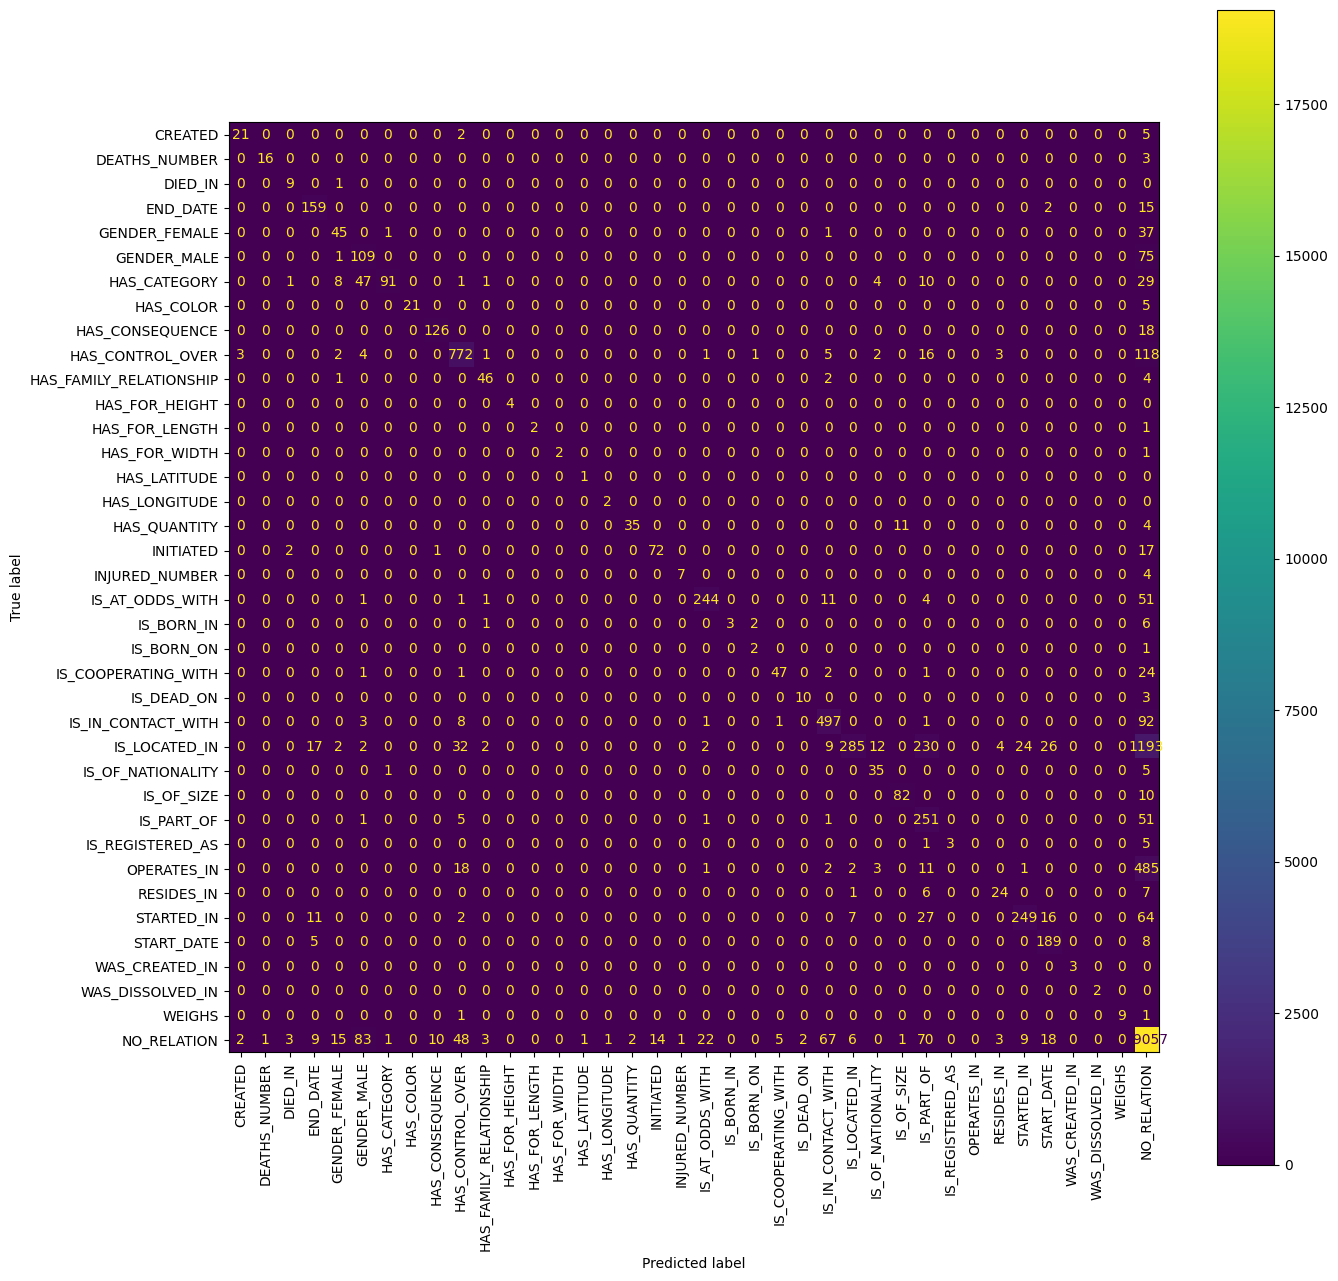

In [44]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=mlb.classes_.tolist() + ["NO_RELATION"])
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax, xticks_rotation = 'vertical')
plt.show()